In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Initial Analysis

In [2]:
df = pd.read_csv('train.csv')
df_submit = pd.read_csv('test.csv')

In [3]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### Missing Values

% of missing values in train...

In [5]:
df.isnull().sum()/len(df)*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

...and submit datasets

In [6]:
df_submit.isnull().sum()/len(df_submit)*100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

### Finding 1 => Initial Analysis and missing values.
- We will have to transform column and data to lowercase, remove spaces, etc
- There are categorical variables (PassengerId and Cabin) than we can split in order to obtain several useful features
    - *PassengerId* : Number of members in a group
    - *Cabin* : Deck, Number, Side
- There are missing values in both train and submit datasets, but in a small percentage (< 2.5%). We can replace them with the most frequent values ​​without too much loss of accuracy

## Data Preparation

Adaptating categorical columns

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.cryosleep = pd.to_numeric(df.cryosleep, errors='coerce')
df.vip = pd.to_numeric(df.vip, errors='coerce')
df.transported = pd.to_numeric(df.transported, errors='coerce')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

Split of PassengerId (id / size)

In [8]:
df['groupid'] = df['passengerid'].apply(lambda x: int(x[:4]))
gr = pd.DataFrame(df['groupid'].value_counts()).reset_index().rename({'index': 'groupid', 
                      'groupid': 'groupsize'}, axis=1)
df = df.merge(gr, on='groupid', how='left')

Split of Cabin (deck / number / side)

In [9]:
splitcabin = df['cabin'].str.split('/', expand=True).rename({0: 'deck', 1: 'num', 2: 'side'}, axis=1)
df = df.merge(splitcabin, left_index=True, right_index=True, how='left')

I won't use identifier variables (passengerid, cabin, name, groupid, num)

In [10]:
df = df.drop(columns = ['passengerid', 'cabin', 'name', 'groupid', 'num'])

In [11]:
df.describe()

,cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,groupsize
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,2.035546
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,3.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [12]:
df.describe(include = ['O'])

,homeplanet,destination,deck,side
count,8492,8511,8494,8494
unique,3,3,8,2
top,earth,trappist-1e,f,s
freq,4602,5915,2794,4288


In order to correct missing values I'm going to impute:
- mean() value in numerical features
- most frequent value in categorical ones

In [13]:
df.cryosleep = df.cryosleep.fillna(df.cryosleep.median()).astype(int)
df.age = df.age.fillna(df.age.mean()).astype(int)
df.vip = df.vip.fillna(df.vip.median()).astype(int)
df.roomservice = df.roomservice.fillna(df.roomservice.mean()).astype(int)
df.foodcourt = df.foodcourt.fillna(df.foodcourt.mean()).astype(int)
df.shoppingmall = df.shoppingmall.fillna(df.shoppingmall.mean()).astype(int)
df.spa = df.spa.fillna(df.spa.mean()).astype(int)
df.vrdeck = df.vrdeck.fillna(df.spa.mean()).astype(int)
df.groupsize = df.groupsize.fillna(df.groupsize.mean()).astype(int)
df.homeplanet = df.homeplanet.fillna('earth')
df.destination = df.destination.fillna('trappist-1e')
df.deck = df.deck.fillna('f')
df.side = df.side.fillna('s')

In [14]:
df.isnull().sum()/len(df)*100

homeplanet      0.0
cryosleep       0.0
destination     0.0
age             0.0
vip             0.0
roomservice     0.0
foodcourt       0.0
shoppingmall    0.0
spa             0.0
vrdeck          0.0
transported     0.0
groupsize       0.0
deck            0.0
side            0.0
dtype: float64

In [15]:
df.dtypes

homeplanet      object
cryosleep        int32
destination     object
age              int32
vip              int32
roomservice      int32
foodcourt        int32
shoppingmall     int32
spa              int32
vrdeck           int32
transported       bool
groupsize        int32
deck            object
side            object
dtype: object

In [16]:
df.nunique()

homeplanet         3
cryosleep          2
destination        3
age               80
vip                2
roomservice     1273
foodcourt       1507
shoppingmall    1116
spa             1327
vrdeck          1306
transported        2
groupsize          8
deck               8
side               2
dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

def split_dataframe(dataframe): 
  df_full_train, df_test = train_test_split(dataframe, test_size=0.2, random_state=1)

  df_full_train = df_full_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  #y_train = df_train.trip_duration.values
  #y_val = df_val.trip_duration.values
  #y_test = df_test.trip_duration.values

  return df_full_train, df_test

  # df_train.drop(columns=['trip_duration'], inplace=True)
  # df_val.drop(columns=['trip_duration'], inplace=True)

In [18]:
df_rest, df_tmp = train_test_split(df, test_size=0.1, random_state=1)
df_full_train, df_test = split_dataframe(df_tmp)

#### We impute missing_values
- Categorical: Space
- Numerical: Zero or mean()

In [19]:
# Imputamos los distintos valores



In [20]:
df

,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,groupsize,deck,side
0,europa,0,trappist-1e,39,0,0,0,0,0,0,False,1,b,p
1,earth,0,trappist-1e,24,0,109,9,25,549,44,True,1,f,s
2,europa,0,trappist-1e,58,1,43,3576,0,6715,49,False,2,a,s
3,europa,0,trappist-1e,33,0,0,1283,371,3329,193,False,2,a,s
4,earth,0,trappist-1e,16,0,303,70,151,565,2,True,1,f,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,europa,0,55_cancri_e,41,1,0,6819,0,1643,74,False,1,a,p
8689,earth,1,pso_j318.5-22,18,0,0,0,0,0,0,False,1,g,s
8690,earth,0,trappist-1e,26,0,0,0,1872,1,0,True,1,g,s
8691,europa,0,55_cancri_e,32,0,0,1049,0,353,3235,False,2,e,s


In [21]:
df.dtypes

homeplanet      object
cryosleep        int32
destination     object
age              int32
vip              int32
roomservice      int32
foodcourt        int32
shoppingmall     int32
spa              int32
vrdeck           int32
transported       bool
groupsize        int32
deck            object
side            object
dtype: object

#### Cambios
- Pasar booleanos a 0-1

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
# Functions to calculate Logistic Regression model
def LR_train(df_train, df_val, features):
    # OHE
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_train = df_train.transported.values

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    return(model,X_train,X_val)
  
def LR_predict(X_train, X_val, model):
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_val = model.predict_proba(X_val)[:, 1]

    return(y_pred_train, y_pred_val)

def LR_calculate(features, n_splits=5): # Number of splits for Cross validation by default is 3 because it's a very large dataset
    # Cross-Validating
    print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        model, X_train, X_val = LR_train(df_train, df_val, features)
        y_pred_train, y_pred_val = LR_predict(X_train, X_val, model)

        y_train = df_train.transported.values
        y_val = df_val.transported.values
        scores_train.append(round(roc_auc_score(y_train, y_pred_train),4))
        scores_val.append(round(roc_auc_score(y_val, y_pred_val),4))

        # Calculates and prints metrics
        print(f'Fold {fold} ROC_AUC train: {round(roc_auc_score(y_train, y_pred_train),4)} ROC_AUC val: {round(roc_auc_score(y_val, y_pred_val),4)}...')
        fold = fold + 1

    print('Validation results:')
    print('ROC_AUC_train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    print('ROC_AUC_val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    print("Final model...")
    model, X_train, X_test = LR_train(df_full_train, df_test, features)
    y_pred_train, y_pred_test = LR_predict(X_train, X_test, model)

    y_train = df_full_train.transported.values
    y_test = df_test.transported.values
   
    print('ROC_AUC train: ',round(roc_auc_score(y_train, y_pred_train),4), ' ROC_AUC test: ',round(roc_auc_score(y_test, y_pred_test),4))

In [25]:
features = ['homeplanet', 'cryosleep', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'groupsize', 'deck', 'side']
LR_calculate(features)

Doing validation with 5 splits


C:\Users\gmani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 0 ROC_AUC train: 0.8978 ROC_AUC val: 0.8761...


C:\Users\gmani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1 ROC_AUC train: 0.8865 ROC_AUC val: 0.9159...
Fold 2 ROC_AUC train: 0.8942 ROC_AUC val: 0.8813...


C:\Users\gmani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3 ROC_AUC train: 0.9112 ROC_AUC val: 0.8099...
Fold 4 ROC_AUC train: 0.8893 ROC_AUC val: 0.9021...
Validation results:
ROC_AUC_train: 0.896 +- 0.009
ROC_AUC_val: 0.877 +- 0.037
Final model...
ROC_AUC train:  0.894  ROC_AUC test:  0.8965


C:\Users\gmani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Findings about Linear Regression model
1. ROC_AUC = 0.8978. Great result !

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [27]:
# Functions to calculate Decision Tree model
def DT_train(df_train, df_val, features, max_d):
    # OHE
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    #X_train = df_train[features].values
    #X_val = df_val[features].values

    y_train = df_train.transported.values

    model = DecisionTreeClassifier(max_depth=max_d, random_state=1)
    model.fit(X_train, y_train)

    return(dv,model,X_train,X_val)
  
def DT_predict(X_train, X_val, model):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    return(y_pred_train, y_pred_val)

def DT_calculate(features, max_d=None, print_ft_tree=False, n_splits=5):
    # Cross-Validating
    print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0
    dv = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model, X_train, X_val = DT_train(df_train, df_val, features, max_d)
        y_pred_train, y_pred_val = DT_predict(X_train, X_val, model)

        y_train = df_train.transported.values
        y_val = df_val.transported.values
        scores_train.append(round(roc_auc_score(y_train, y_pred_train),4))
        scores_val.append(round(roc_auc_score(y_val, y_pred_val),4))

        # Calculates and prints metrics
        print(f'Fold {fold} ROC_AUC train: {round(roc_auc_score(y_train, y_pred_train),4)} ROC_AUC val: {round(roc_auc_score(y_val, y_pred_val),4)}...')
        fold = fold + 1

    print('Validation results:')
    print('ROC_AUC_train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    print('ROC_AUC_val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    print("Final model...")
    dv, model, X_train, X_test = DT_train(df_full_train, df_test, features, max_d)
    y_pred_train, y_pred_test = DT_predict(X_train, X_test, model)

    y_train = df_full_train.transported.values
    y_test = df_test.transported.values
   
    print('ROC_AUC train: ',round(roc_auc_score(y_train, y_pred_train),4), ' ROC_AUC test: ',round(roc_auc_score(y_test, y_pred_test),4))
 
    # Feature importances
    features = dv.get_feature_names_out()
    if print_ft_tree:
      print('Feature importances')
      for n,value in enumerate(features):
        print(features[n],': ',model.feature_importances_[n])
    """
    if print_ft_tree:
      # Tree
      print('DecisionTree')
      print(export_text(model, feature_names=features))
    """
    return(round(roc_auc_score(y_test, y_pred_test),4), model)

In [28]:
features = ['homeplanet', 'cryosleep', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'groupsize', 'deck', 'side']
DT_calculate(features, 10, True)

Doing validation with 5 splits
Fold 0 ROC_AUC train: 0.963 ROC_AUC val: 0.75...
Fold 1 ROC_AUC train: 0.9278 ROC_AUC val: 0.7767...
Fold 2 ROC_AUC train: 0.952 ROC_AUC val: 0.7003...
Fold 3 ROC_AUC train: 0.9517 ROC_AUC val: 0.6661...
Fold 4 ROC_AUC train: 0.9353 ROC_AUC val: 0.6831...
Validation results:
ROC_AUC_train: 0.946 +- 0.013
ROC_AUC_val: 0.715 +- 0.042
Final model...
ROC_AUC train:  0.9374  ROC_AUC test:  0.7925
Feature importances
age :  0.10359886653810446
cryosleep :  0.27276071937755547
deck=a :  0.0
deck=b :  0.005906387447206114
deck=c :  0.0048121436337616565
deck=d :  0.004929151743046717
deck=e :  0.0034658098193297245
deck=f :  0.00369686380728504
deck=g :  0.051370093926853364
destination=55_cancri_e :  0.0
destination=pso_j318.5-22 :  0.009189574517914315
destination=trappist-1e :  0.02535992558709547
foodcourt :  0.10945354792792329
groupsize :  0.02548784572075019
homeplanet=earth :  0.0010397429457989168
homeplanet=europa :  0.01964315718883575
homeplanet=mars 

(0.7925, DecisionTreeClassifier(max_depth=10, random_state=1))

### Findings about Decission Tree model
1. ROC_AUC = 0.7925. It gets a worse result than the logistic regression model
2. The most important features are cryosleep, luxury amenities, age, and deck=g

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
# Functions to calculate Random Forest model
def RF_train(df_train, df_val, features, n_est, max_d):
    # OHE
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_train = df_train.transported.values

    model = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)

    return(dv,model,X_train,X_val)
  
def RF_predict(X_train, X_val, model):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    return(y_pred_train, y_pred_val)

def RF_calculate(features, n_est=100, max_d=None, print_ft=False, print_kfold=True, n_splits=5):
    # Cross-Validating
    if print_kfold: print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0
    dv = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model, X_train, X_val = RF_train(df_train, df_val, features, n_est, max_d)
        y_pred_train, y_pred_val = RF_predict(X_train, X_val, model)

        y_train = df_train.transported.values
        y_val = df_val.transported.values
        scores_train.append(round(roc_auc_score(y_train, y_pred_train),4))
        scores_val.append(round(roc_auc_score(y_val, y_pred_val),4))

        # Calculates and prints metrics
        if print_kfold: print(f'Fold {fold} ROC_AUC train: {round(roc_auc_score(y_train, y_pred_train),4)} ROC_AUC val: {round(roc_auc_score(y_val, y_pred_val),4)}...')
        fold = fold + 1

    if print_kfold: print('Validation results:')
    if print_kfold: print('ROC_AUC_train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    if print_kfold: print('ROC_AUC_val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    print("Final model...")
    dv, model, X_train, X_test = RF_train(df_full_train, df_test, features, n_est, max_d)
    y_pred_train, y_pred_test = RF_predict(X_train, X_test, model)

    y_train = df_full_train.transported.values
    y_test = df_test.transported.values
   
    print('ROC_AUC train: ',round(roc_auc_score(y_train, y_pred_train),4), ' ROC_AUC test: ',round(roc_auc_score(y_test, y_pred_test),4))
 
    # Feature importances
    features = dv.get_feature_names_out()
    if print_ft:
      print('Feature importances')
      for n,value in enumerate(features):
        print(features[n],': ',model.feature_importances_[n])
      
    return(round(roc_auc_score(y_train, y_pred_train),4), round(roc_auc_score(y_test, y_pred_test),4), model)

In [31]:
features = ['homeplanet', 'cryosleep', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'groupsize', 'deck', 'side']
RF_calculate(features, 100, 15, True, True)

Doing validation with 5 splits
Fold 0 ROC_AUC train: 0.9997 ROC_AUC val: 0.8398...
Fold 1 ROC_AUC train: 0.9997 ROC_AUC val: 0.8948...
Fold 2 ROC_AUC train: 0.9999 ROC_AUC val: 0.8567...
Fold 3 ROC_AUC train: 1.0 ROC_AUC val: 0.7543...
Fold 4 ROC_AUC train: 0.9999 ROC_AUC val: 0.8529...
Validation results:
ROC_AUC_train: 1.000 +- 0.000
ROC_AUC_val: 0.840 +- 0.046
Final model...
ROC_AUC train:  0.9999  ROC_AUC test:  0.9
Feature importances
age :  0.1524146362826277
cryosleep :  0.23472778398897154
deck=a :  0.001884380412978413
deck=b :  0.0044040720442726855
deck=c :  0.004543305838986941
deck=d :  0.0015846516521583697
deck=e :  0.006765809607569554
deck=f :  0.00973552777193563
deck=g :  0.038606175978401804
destination=55_cancri_e :  0.009786498554172577
destination=pso_j318.5-22 :  0.009803789973427735
destination=trappist-1e :  0.01347630406229872
foodcourt :  0.09786766496732424
groupsize :  0.040704011415642456
homeplanet=earth :  0.013329149732689739
homeplanet=europa :  0.005

(0.9999, 0.9, RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1))

### Findings about Random Forest model
1. ROC_AUC = 0.9000. Slightly improves previous models
2. The most important features are cryosleep, age and luxury amenities

## XGBoost

In [32]:
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [33]:
features = ['homeplanet', 'cryosleep', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'groupsize', 'deck', 'side']
            
train_dicts = df_full_train[features].to_dict(orient='records')
val_dicts = df_test[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False) # OHE
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_full_train.transported.values
y_val = df_test.transported.values

features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [34]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [39]:
%%capture output

score = []
for eta in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
  for md in [2, 4, 6, 8, 10, 15]:
    xgb_params = {'eta': eta, 'max_depth': md, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'nthread': 8, 'seed': 1, 'verbosity': 1}   
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)
    for ni in range(0,201,5):
      score.append((eta, md))

df_score = pd.DataFrame(score, columns=['eta', 'max_depth'])
df_parse = parse_xgb_output(output)
df_score = pd.concat([df_score, df_parse], axis=1)

In [40]:
df_score.describe()

,eta,max_depth,num_iter,train_auc,val_auc
count,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000
mean,0.165857,7.500000,99.975610,0.961880,0.883958
std,0.169097,4.234038,59.136931,0.044984,0.018686
min,0.001000,2.000000,0.000000,0.790890,0.784460
25%,0.010000,4.000000,50.000000,0.937915,0.873930
50%,0.100000,7.000000,100.000000,0.979185,0.885185
75%,0.300000,10.000000,150.000000,0.998865,0.898320
max,0.500000,15.000000,199.000000,0.999930,0.919140


In [41]:
df_score[df_score.val_auc >= 0.9].sort_values("val_auc", ascending=False).head(10)

,eta,max_depth,num_iter,train_auc,val_auc
1238,0.3,2,40,0.92913,0.91914
1239,0.3,2,45,0.93457,0.91880
1241,0.3,2,55,0.93888,0.91854
1240,0.3,2,50,0.93669,0.91814
824,0.1,6,20,0.95385,0.91607
1237,0.3,2,35,0.92619,0.91526
1031,0.2,4,30,0.95602,0.91446
823,0.1,6,15,0.94653,0.91406
1242,0.3,2,60,0.94149,0.91400
825,0.1,6,25,0.96263,0.91306


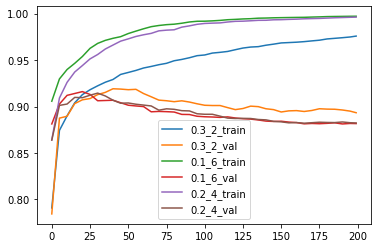

In [42]:
df_plot = df_score[df_score.eta == 0.3]
df_plot = df_plot[df_plot.max_depth == 2]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.3_2_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.3_2_val')

df_plot = df_score[df_score.eta == 0.1]
df_plot = df_plot[df_plot.max_depth == 6]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.1_6_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.1_6_val')

df_plot = df_score[df_score.eta == 0.2]
df_plot = df_plot[df_plot.max_depth == 4]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.2_4_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.2_4_val')

plt.legend()

### Findings about XGB Forest model
It seems that the model with the best performance is (ETA: 0.3 max_depth 2 num_iter= 40) that
1. Slightly improves previous models. ROC_AUC = 0.91306
2. Has less overfitting

### Training and saving the XGB final model

Training and Kfold validating

In [43]:
# Functions to calculate XGBoost model
def XGB_train(df_train, df_val, features, xgb_params, num_rounds):
    train_dicts = df_train[features].to_dict(orient='records')
    val_dicts = df_val[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False) # OHE
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    y_train = df_train.transported.values
    y_val = df_val.transported.values
    
    features = dv.get_feature_names_out()
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    model = xgb.train(xgb_params, dtrain, num_boost_round=num_rounds)

    return(dv,model,dtrain,dval)
  
def XGB_predict(dtrain, dval, model):
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)

    return(y_pred_train, y_pred_val)

def XGB_calculate(features, xgb_params, num_rounds=100, print_kfold=True, print_summary=True,n_splits=5):
    # Cross-Validating
    print('ETA: ', xgb_params['eta'], 'max_depth: ', xgb_params['max_depth'], 'num_rounds: ', num_rounds)
    if print_kfold: print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model, dtrain, dval = XGB_train(df_train, df_val, features, xgb_params, num_rounds)
        y_pred_train, y_pred_val = XGB_predict(dtrain, dval, model)

        y_train = df_train.transported.values
        y_val = df_val.transported.values
        scores_train.append(round(roc_auc_score(y_train, y_pred_train),4))
        scores_val.append(round(roc_auc_score(y_val, y_pred_val),4))

        # Calculates and prints metrics
        if print_kfold: print(f'Fold {fold} ROC_AUC train: {round(roc_auc_score(y_train, y_pred_train),4)} ROC_AUC val: {round(roc_auc_score(y_val, y_pred_val),4)}...')
        fold = fold + 1

    if print_kfold: print('Validation results:')
    if print_kfold: print('ROC_AUC train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    if print_kfold: print('ROC_AUC val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    if print_summary: print("Final model...")
    dv, model, dtrain, dtest = XGB_train(df_full_train, df_test, features, xgb_params, num_rounds)
    y_pred_train, y_pred_test = XGB_predict(dtrain, dtest, model)

    y_train = df_full_train.transported.values
    y_test = df_test.transported.values
   
    if print_summary: print('ROC_AUC train: ',round(roc_auc_score(y_train, y_pred_train),4), ' ROC_AUC test: ',round(roc_auc_score(y_test, y_pred_test),4))
      
    return [xgb_params['eta'], xgb_params['max_depth'], num_rounds,
          round(roc_auc_score(y_train, y_pred_train),4), round(roc_auc_score(y_test, y_pred_test),4)
          ], dv, model

In [44]:
features = ['homeplanet', 'cryosleep', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'groupsize', 'deck', 'side']    
xgb_params = {'eta': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'objective': 'binary:logistic', 'nthread': 8, 'seed': 1, 'verbosity': 1}            
sc,dv,model= XGB_calculate(features, xgb_params, 40, True, True, 10)

ETA:  0.3 max_depth:  2 num_rounds:  40
Doing validation with 10 splits
Fold 0 ROC_AUC train: 0.9361 ROC_AUC val: 0.8256...
Fold 1 ROC_AUC train: 0.9292 ROC_AUC val: 0.8685...
Fold 2 ROC_AUC train: 0.9264 ROC_AUC val: 0.8791...
Fold 3 ROC_AUC train: 0.9317 ROC_AUC val: 0.912...
Fold 4 ROC_AUC train: 0.9313 ROC_AUC val: 0.8705...
Fold 5 ROC_AUC train: 0.9273 ROC_AUC val: 0.889...
Fold 6 ROC_AUC train: 0.9341 ROC_AUC val: 0.7542...
Fold 7 ROC_AUC train: 0.9364 ROC_AUC val: 0.7597...
Fold 8 ROC_AUC train: 0.9293 ROC_AUC val: 0.8941...
Fold 9 ROC_AUC train: 0.9306 ROC_AUC val: 0.8824...
Validation results:
ROC_AUC train: 0.931 +- 0.003
ROC_AUC val: 0.854 +- 0.053
Final model...
ROC_AUC train:  0.9282  ROC_AUC test:  0.9191


In [45]:
model.get_score(importance_type='gain')

{'age': 2.097374439239502,
 'cryosleep': 89.73260498046875,
 'deck=a': 0.2523479461669922,
 'deck=c': 3.0203444957733154,
 'deck=g': 17.184673309326172,
 'destination=55_cancri_e': 3.0814247131347656,
 'destination=trappist-1e': 4.196163177490234,
 'foodcourt': 4.963813304901123,
 'groupsize': 1.7509393692016602,
 'homeplanet=earth': 7.674045562744141,
 'homeplanet=europa': 7.540081024169922,
 'homeplanet=mars': 4.396103382110596,
 'roomservice': 9.765000343322754,
 'shoppingmall': 4.670716285705566,
 'side=p': 3.6510543823242188,
 'spa': 7.467918872833252,
 'vrdeck': 5.533143997192383}

Previous findings regarding the importance of features cryosleep and deck=g are confirmed.

Saving the model using pickle

In [46]:
import pickle

with open('XGB_model.bin', 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

# Summary
In this notebook I have:
1. Done an analysis on the original dataset and verified that the dataset is in good condition but has many missing values
2. Prepared the dataset and created 2 new variables extracting data from Cabin and PassengerId
3. Compared the ROC_AUC of all model types studied in the course
4. Chosen and tuned a XGBBoost model that is slightly better than the rest

In [47]:
model_file = 'XGB_model.bin'
with open(model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

passenger = {
  "homeplanet": "europa",
  "cryosleep": 0,
  "cabin": "e/608/s",
  "destination": "55_cancri_e",
  "age": 32,
  "vip": 0,
  "roomservice": 0,
  "foodcourt": 0,
  "shoppingmall": 0,
  "spa": 0,
  "vrdeck": 0
}

X = dv.transform(passenger)
features = dv.get_feature_names_out()
dX = xgb.DMatrix(X, feature_names=features)
y_pred = model.predict(dX)

y_pred
#passenger


array([0.88201535], dtype=float32)